In [352]:
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from __future__ import division
from code.colloid_polymer_free_energy import Acp
import sys
sys.path.append('../')
from regression.code.bond_volume import BondVolume
import warnings
%matplotlib inline 

### Ideal free energy contribution

---

In [2]:
def Aid(p_c, p_p, 
        d_c, d_p  
       ):
    
    #just creating an arbitrary length scale to non-dimensionalize the log term
    vol = (d_c/2.0 + d_p/2.0)**3.0
    p = p_c + p_p
    
    #ideal contribution containing both mixing and translational entropy
    a_id = p_c*np.log(p_c*vol) + p_p*np.log(p_p*vol) - p
    
    return a_id

### Reference free energy contribution

This is a hard mixture of colloids with polymer chains

---

Contact values between a reference hard sphere mixture

In [3]:
def G(p_cs, p_ps,     
      d_c, d_p,       
      type_1, type_2  
      ):
    
    #auxillary hard sphere parameters
    e2 = (np.pi/6.0)*(p_cs*d_c**2 + p_ps*d_p**2)
    e3 = (np.pi/6.0)*(p_cs*d_c**3 + p_ps*d_p**3)
    
    #type specific details
    r_1 = (type_1 == 'c')*d_c/2.0 + (type_1 == 'p')*d_p/2.0
    r_2 = (type_2 == 'c')*d_c/2.0 + (type_2 == 'p')*d_p/2.0
    
    #cross contact value
    g = ( 1.0/(1.0 - e3) 
        + 6.0*e2*r_1*r_2/((r_1 + r_2)*(1.0 - e3)**2) 
        + 8.0*(e2**2)*(r_1**2)*(r_2**2)/(((1.0 - e3)**3)*((r_1+r_2)**2))  
        )
    
    return g

Total reference free energy of a colloid-polymer mixture

In [4]:
def Aref(p_c, p_p, 
         d_c, d_p, m
        ):
    
    #total molecular density and molecular mole fractions
    p = p_c + p_p
    x_c = p_c/p
    x_p = p_p/p
    
    #site level densities
    p_cs = p_c
    p_ps = m*p_p
    p_s = p_cs + p_ps
    
    #auxillary hard sphere parameters
    e0 = (np.pi/6.0)*(p_cs + p_ps)
    e1 = (np.pi/6.0)*(p_cs*d_c + p_ps*d_p)
    e2 = (np.pi/6.0)*(p_cs*d_c**2 + p_ps*d_p**2)
    e3 = (np.pi/6.0)*(p_cs*d_c**3 + p_ps*d_p**3)
    
    #monomer free energy per molecule
    a_mon = (p_s/p)*((6.0/(np.pi*p_s))*(((e2**3/e3**2) - e0)*np.log(1.0 - e3) 
                                        + (3.0*e1*e2/(1.0-e3)) + (e2**3/(e3*(1.0-e3)**2))))
    
    #chain free energy change per molecule
    g = G(p_cs, p_ps, d_c, d_p, type_1='p', type_2='p')
    a_chn = -x_p*(m - 1.0)*np.log(g)
    
    #free energy per total number of "molecules"
    a_ref = a_mon + a_chn
    
    #convert to free energy per volume
    return a_ref*p

### Bonding free energy contribution

This uses a ML based prediction for the bond volume and hard sphere mixture structure

---

ONLY valid for dc=5 and dp=1 right now!!!!!!

In [5]:
r = np.arange(0.0, 7.0, 0.005)

In [6]:
#ML prediction for the average mayer-f function
bond_volume = BondVolume(model_index=0, num_rbfs=5)
bond_volume.InitializePredictionGrid(rs=r)
BV = lambda x: bond_volume.Predict(x)

Function that calculates the bond integral

In [7]:
def BIcp(p_c, p_p, e_pc,  
         d_c, d_p, m   
        ):
    
    #get the average mayer-f function
    f_cp_avg = BV(e_pc)
    
    #get the structure for the dis-assembled hard sphere reference
    p_cs = p_c
    p_ps = p_p*m
    g_cp = G(p_cs, p_ps, d_c, d_p, type_1='c', type_2='p')
    r_cut = (d_c + d_p)/2.0
    
    #define integrand above the hard core
    integrand = 4.0*np.pi*r*r*f_cp_avg*g_cp*(r > r_cut)
    bi_cp = np.trapz(integrand, r)
    
    return bi_cp

Calculate the fraction of sites not bonded

In [8]:
def X(p_c, p_p, e_pc,    
      d_c, d_p, m_c, m_p, m  
      ):
    
    #get the bond integral
    bi_cp = BIcp(p_c, p_p, e_pc, d_c, d_p, m)
    
    #total density
    p = p_c + p_p
    
    #species fractions
    f_c = p_c/p
    f_p = p_p/p
    
    #analytical formula for X_c and X_p
    X_c = 2.0 / (1.0 + m_p*p*bi_cp - f_c*(m_c + m_p)*p*bi_cp 
                 + np.sqrt(4.0*f_c*m_c*p*bi_cp + np.power(-1.0 + (-m_p + f_c*(m_c + m_p))*p*bi_cp, 2.0)))
    X_p = 2.0 / (1.0 - m_p*p*bi_cp + f_c*(m_c + m_p)*p*bi_cp 
                 + np.sqrt(4.0*f_c*m_c*p*bi_cp + np.power(-1.0 + (-m_p + f_c*(m_c + m_p))*p*bi_cp, 2.0)))
    
    return (X_c, X_p)

In [9]:
def Perc(p_c, p_p, e_pc,    
         d_c, d_p, m_c, m_p, m  
         ):
    
    #bonded fraction of each species
    X_c, X_p = X(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m)
    
    return 1.0 - (m_p - 1.0)*(1.0 - X_p)*(m_c - 1.0)*(1.0 - X_c)

In [10]:
def Abd(p_c, p_p, e_pc,              
        d_c, d_p, m_c, m_p, m  
        ):
    
    #bonded fraction of each species
    X_c, X_p = X(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m)
    
    #excess bonding free energy
    a_bd = p_c*(m_c*np.log(X_c) - m_c*X_c/2.0 + m_c/2.0) + p_p*(m_p*np.log(X_p) - m_p*X_p/2.0 + m_p/2.0)
    
    return a_bd

###   Total free energy per volume and pressure

---

In [11]:
def A(p_c, p_p, e_pc,        
      d_c, d_p, m_c, m_p, m  
      ):
    
    #get the free energies
    a_id = Aid(p_c, p_p, d_c, d_p)
    a_ref = Aref(p_c, p_p, d_c, d_p, m)
    a_bd = Abd(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m)
    
    return a_id + a_ref + a_bd

In [12]:
def Z(p, x_c, e_pc,        
      d_c, d_p, m_c, m_p, m 
      ):
    
    #molecular densities
    p_c = x_c*p
    p_p = (1.0 - x_c)*p
    
    A_ = lambda o: A(x_c*o, (1.0 - x_c)*o, e_pc, d_c, d_p, m_c, m_p, m)/o
    dAdp = nd.Derivative(A_, n=1, step=1e-5)
    
    return p*dAdp(p)

Test for pure polymer case and comparison to fig 2 in Mol. Phys., 65:5, 1057-1079

/home/ryanj/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/ryanj/miniconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ryanj/miniconda2/lib/python2.7/site-packages/numdifftools/limits.py:126: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


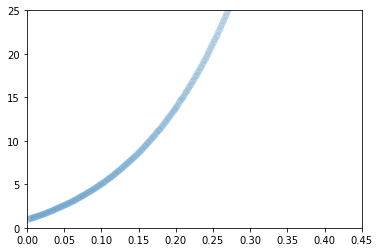

In [13]:
#for pure polymer
x_c = 0.0001
e_pc = 0.0
d_c = 1.0
d_p = 1.0
m_c = 1
m_p = 1
m = 16
ns = np.arange(0.0,0.50,0.001)
ps = (6*ns/(np.pi*d_p**3))/m

Zs = []
for p in ps:
    Zs.append(Z(p, x_c, e_pc, d_c, d_p, m_c, m_p, m))

#Zs = m*((1+ns+ns**2-ns**3)/(1-ns)**3 - ((m-1)/m)*(1+ns-(ns**2)/2)/((1-ns)*(1-ns/2)))

plt.xlim(0,0.45)
plt.ylim(0,25)

#plt.scatter(ns, Zcps)
plt.scatter(ns, Zs, alpha=0.09)

###   Stabilility and percolation calculation
Here we calculate the stability limits of the system via a standard spinodal calculation. For the helmholts free energy we only need to look at any determnant that contains n-1 degrees of freedom where n counts all the extensive variables.

---

In [14]:
def DA(p_c, p_p, e_pc,              #state variables
       d_c, d_p, m_c, m_p, m, #system parameters
       min_step                  #minimum step to use for hessian calculation
      ):
    
    #generate steps for calculating hessian
    hess_steps = nd.MinStepGenerator(base_step=min_step, step_ratio=2.0, num_steps=4)
    
    #calculate the hessian (stability matrix)
    calculate_hessian = lambda x: A(x[0], x[1], e_pc, d_c, d_p, m_c, m_p, m)
    stability_matrix = nd.Hessian(calculate_hessian, step=hess_steps)([p_c, p_p])
    
    #build the 3x3 (or 2x2) stability matrix as a numpy array and calculate the determinant 
    #logdet is used to avoid issues with a small determinant (such as when an instability is reached)
    (sign, logdet) = np.linalg.slogdet(stability_matrix)
    stability_determinant = sign*np.exp(logdet)    
        
    #return the stability determinant
    return stability_determinant

In [267]:
import scipy as sp

#performs grid search and labels each point as stable or unstable
def CalculateBoundary(p_c_vals, gamma, e_pc_vals,
                      d_c, d_p, m_c, m_p, m,
                      min_step, boundary_type,
                     ):


    #lists for storing the results
    boundary = [[],[],[],[]]

    #quantities to iterate over
    #p_c_vals_rev = list(reversed(p_c_vals))
    quants = {'p_c': p_c_vals,
              'e_pc': e_pc_vals}

    #iteration permutations
    iters = [('p_c', 'e_pc'), 
             ('e_pc', 'p_c')]
    #iters = [('e_pc', 'p_c')]

    #perform the loops in both directions
    for iter_1, iter_2 in iters:
        
        print "Performing ({}, {}) iteration...".format(iter_1, iter_2)

        for quant_1 in quants[iter_1]:

            #stacks to find crossover points iterating over quant_2
            value_queue = []
            quant_2_queue = []
            q0 = None

            for quant_2 in quants[iter_2]:

                #extract the values
                p_c = (iter_1 == 'p_c')*quant_1 + (iter_2 == 'p_c')*quant_2
                p_p = p_c*gamma
                e_pc = (iter_1 == 'e_pc')*quant_1 + (iter_2 == 'e_pc')*quant_2

                #perform the appropriate calculation
                if boundary_type == 'spinodal':
                    value = DA(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m, min_step)
                elif boundary_type == 'percolation':
                    value = Perc(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m)
                elif boundary_type == 'binodal':
                    value, q0 = PS(p_c+p_p, p_c/p_p, e_pc, d_c, d_p, m_c, m_p, m, q0, threshold=1.0e-6)

                #manage the queue
                if len(value_queue) == 4:
                    value_queue.pop(0); quant_2_queue.pop(0)
                value_queue.append(value); quant_2_queue.append(quant_2)

                #count the number of unstable points encountered
                ####num_neg = num_neg + (value < 0.0)

                #if we have two positive and negative points interpolate to find the crossover and break
                ####if num_neg == 2:
                if len(value_queue) == 4:
                    value_queue_sgn = np.sign(value_queue)
                    if np.all(value_queue_sgn[0:2] + value_queue_sgn[2:] == 0):

                        #fit an akima spline
                        fit = sp.interpolate.Akima1DInterpolator(quant_2_queue, value_queue)
                        roots = fit.roots()

                        #select which one to use and append
                        num_roots = len(roots)
                        p_c_ = (iter_1 == 'p_c')*p_c + (iter_2 == 'p_c')*( (num_roots == 1)*roots[0] - (num_roots != 1) )
                        e_pc_ = (iter_1 == 'e_pc')*e_pc + (iter_2 == 'e_pc')*( (num_roots == 1)*roots[0] - (num_roots != 1) )
                        boundary[0].append( p_c_ )
                        boundary[1].append( p_p )
                        boundary[2].append( e_pc_ )
                        boundary[3].append( ((np.pi/6.0)*d_c**3)*p_c_ )
                        #break

    return boundary

Find the spinodal boundary

In [16]:
def FindSpinodal(gamma, d_c, d_p, m_c, m_p, m,
                 n_c_min, n_c_max, e_pc_min, e_pc_max,
                 num_pts_p_c, num_pts_e_pc, num_pts_p_c_final, num_pts_e_pc_final,
                 min_step, expansion
                ):
    
    #auxillary
    p_c_min = 6.0*n_c_min/(np.pi*d_c**3)
    p_c_max = 6.0*n_c_max/(np.pi*d_c**3)

    #####################################################################################

    #set the ranges
    p_c_vals = np.linspace(p_c_min, p_c_max, num=num_pts_p_c)
    e_pc_vals = np.linspace(e_pc_min, e_pc_max, num=num_pts_e_pc)

    #spinodal
    print "Performing initial spinodal pass with {}x{} grid...".format(num_pts_p_c, num_pts_e_pc)
    spinodal_init = CalculateBoundary(p_c_vals, gamma, e_pc_vals, 
                                      d_c, d_p, m_c, m_p, m, 
                                      min_step, 'spinodal')

    #####################################################################################

    #get the new sampling details
    pc_range_final = max(spinodal_init[0]) - p_c_min
    e_pc_range_final = e_pc_max - min(spinodal_init[2])
    p_c_max_final = p_c_min + pc_range_final*(1.0 + expansion)
    e_pc_min_final = e_pc_max - e_pc_range_final*(1.0 + expansion)

    #set the ranges
    p_c_vals_final = np.linspace(p_c_min, p_c_max_final, num=num_pts_p_c_final)
    e_pc_vals_final = np.linspace(e_pc_min_final, e_pc_max, num=num_pts_e_pc_final)

    #spinodal
    print "Performing final spinodal pass with localized {}x{} grid...".format(num_pts_p_c_final, num_pts_e_pc_final)
    spinodal = CalculateBoundary(p_c_vals_final, gamma, e_pc_vals_final, 
                                 d_c, d_p, m_c, m_p, m, 
                                 min_step, 'spinodal')
    
    return spinodal

In [17]:
def FindPercolation(gamma, d_c, d_p, m_c, m_p, m,
                    n_c_min, n_c_max, e_pc_min, e_pc_max,
                    num_pts_p_c, num_pts_e_pc
                    ):
    
    #auxillary
    p_c_min = 6.0*n_c_min/(np.pi*d_c**3)
    p_c_max = 6.0*n_c_max/(np.pi*d_c**3)

    #####################################################################################

    #set the ranges
    p_c_vals = np.linspace(p_c_min, p_c_max, num=num_pts_p_c)
    e_pc_vals = np.linspace(e_pc_min, e_pc_max, num=num_pts_e_pc)

    #percolation
    print "Performing percolation pass with {}x{} grid...".format(num_pts_p_c, num_pts_e_pc)
    percolation = CalculateBoundary(p_c_vals, gamma, e_pc_vals, 
                                    d_c, d_p, m_c, m_p, m, 
                                    min_step, 'percolation')
    
    return percolation

In [18]:
phase_data = {}

In [19]:
#system variables
#gamma = 3.0
d_c = 5.0
d_p = 1.0
m_c = 6.0
m_p = 2.0 
#m = 8

In [22]:
#search range and search parameters
n_c_min = 0.0001
n_c_max = 0.25
e_pc_min = 10.0
e_pc_max = 20.0
num_pts_p_c = 120
num_pts_e_pc = 120
num_pts_p_c_final = 50
num_pts_e_pc_final = 50
min_step= 0.0000001 #0.00001
expansion = 0.50

In [23]:
#ms = [1, 2, 4, 8, 16]
#gammas = [1, 3, 9]

ms = [16]
gammas = [9]

In [26]:
for m in ms:
    for gamma in gammas:
        print "Working on m = {}, gamma = {}".format(m, gamma)
        
        spinodal = FindSpinodal(gamma, d_c, d_p, m_c, m_p, m,
                                n_c_min, n_c_max, e_pc_min, e_pc_max,
                                num_pts_p_c, num_pts_e_pc, num_pts_p_c_final, num_pts_e_pc_final,
                                min_step, expansion
                                )

        phase_data[(m, gamma)] = {'spinodal': [spinodal[3], spinodal[2]]}

Working on m = 16, gamma = 9
Performing initial spinodal pass with 120x120 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...
Performing final spinodal pass with localized 50x50 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...


In [51]:
#import dill as pickle
#with open('./data/spinodal_examples.pkl', 'wb') as file:
#    pickle.dump(phase_data, file)

In [31]:
#import dill as pickle
#with open('./data/spinodal_examples.pkl', 'rb') as file:
#    phase_data = pickle.load(file)

In [46]:
#search range and search parameters
n_c_min = 0.0001
n_c_max = 0.3
e_pc_min = 0.0
e_pc_max = 20.0
num_pts_p_c = 400
num_pts_e_pc = 100

In [47]:
for m in [1, 2, 4, 8, 16]:
    for gamma in [1, 3, 9]:
        print "Working on m = {}, gamma = {}".format(m, gamma)
        
        percolation = FindPercolation(gamma, d_c, d_p, m_c, m_p, m,
                              n_c_min, n_c_max, e_pc_min, e_pc_max,
                              num_pts_p_c, num_pts_e_pc
                              )

        phase_data[(m, gamma)]['percolation'] =  [percolation[3], percolation[2]]

Working on m = 1, gamma = 1
Performing percolation pass with 400x100 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...
Working on m = 1, gamma = 3
Performing percolation pass with 400x100 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...
Working on m = 1, gamma = 9
Performing percolation pass with 400x100 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...
Working on m = 2, gamma = 1
Performing percolation pass with 400x100 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...
Working on m = 2, gamma = 3
Performing percolation pass with 400x100 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...
Working on m = 2, gamma = 9
Performing percolation pass with 400x100 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...
Working on m = 4, gamma = 1
Performing percolation pass with 400x100 grid...
Performing (p_c, e_pc) iterat

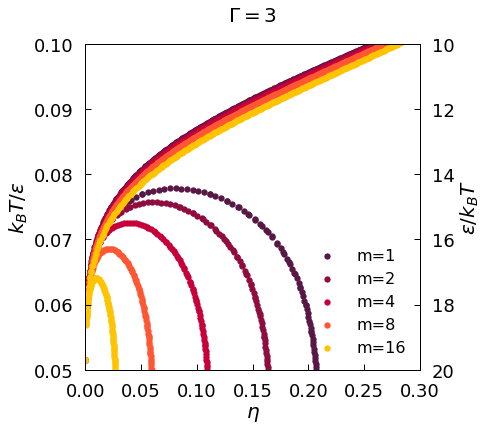

In [129]:
fig=plt.figure()

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#plot the data
gamma = 3
colors = list(reversed(['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']))
#colors = list(reversed(['red', 'orange', 'green', 'blue', 'purple']))
counter = 0
for m in [1,2,4,8,16]:
    
    #spinodal pts
    eta_spinodal, e_pc_spinodal = phase_data[(m, gamma)]['spinodal']
    eta_spinodal, e_pc_spinodal = np.array(eta_spinodal), np.array(e_pc_spinodal)
    eta_spinodal_total = eta_spinodal + m*(d_p**3/d_c**3)*eta_spinodal*gamma
    
    #percolation pts
    eta_percolation, e_pc_percolation = phase_data[(m, gamma)]['percolation']
    eta_percolation, e_pc_percolation = np.array(eta_percolation), np.array(e_pc_percolation)
    eta_percolation_total = eta_percolation + m*(d_p**3/d_c**3)*eta_percolation*gamma
    
    #plot the pts
    plt.scatter(eta_spinodal_total, 1/e_pc_spinodal, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0, label="m={}".format(m))
    plt.scatter(eta_percolation_total, 1/e_pc_percolation, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0)
    counter += 1

#add a legend
plt.legend(loc='lower right', fontsize=16, frameon=False)

#set the ranges
n_c_range = np.array([0.000, 0.30])
e_inv_range = np.array([0.05, 0.10])
e_range = 1.0 / e_inv_range
plt.xlim(tuple(n_c_range))
plt.ylim(tuple(e_inv_range))
#plt.xscale('log')

###primary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlabel('$\eta$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$k_{B}T/\epsilon$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)
plt.title("$\Gamma = {}$".format(gamma), y=1.05, fontdict = title_font)

#make another axis
plt.twinx()
plt.ylim(e_range)

###secondary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.ylabel('$\epsilon / k_{B}T$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)

plt.savefig('./data/colloid_polymer_gamma={}.png'.format(gamma), bbox_inches='tight', dpi=100)

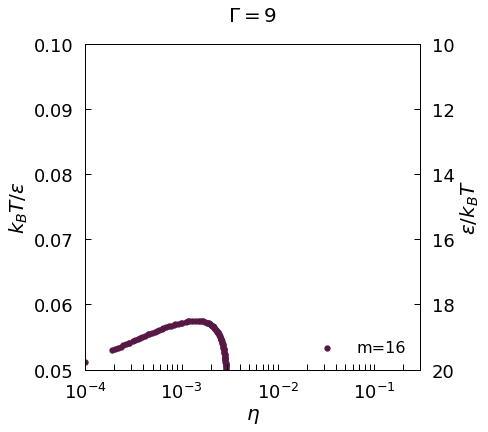

In [30]:
fig=plt.figure()

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#plot the data
gamma = 9
colors = list(reversed(['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']))
#colors = list(reversed(['red', 'orange', 'green', 'blue', 'purple']))
counter = 0
for m in [16]:
    eta_spinodal, e_pc_spinodal = phase_data[(m, gamma)]['spinodal']
    #eta_percolation, e_pc_percolation = phase_data[(m, gamma)]['percolation']
    plt.scatter(eta_spinodal, 1/np.array(e_pc_spinodal), 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0, label="m={}".format(m))
    #plt.scatter(eta_percolation, 1/np.array(e_pc_percolation), 
    #            c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0)
    counter += 1

#add a legend
plt.legend(loc='lower right', fontsize=16, frameon=False)

#set the ranges
n_c_range = np.array([0.0001, 0.30])
e_inv_range = np.array([0.05, 0.10])
e_range = 1.0 / e_inv_range
plt.xlim(tuple(n_c_range))
plt.ylim(tuple(e_inv_range))
plt.xscale('log')

###primary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlabel('$\eta$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$k_{B}T/\epsilon$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)
plt.title("$\Gamma = {}$".format(gamma), y=1.05, fontdict = title_font)

#make another axis
plt.twinx()
plt.ylim(e_range)

###secondary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.ylabel('$\epsilon / k_{B}T$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)

plt.savefig('./data/colloid_polymer_gamma={}.png'.format(gamma), bbox_inches='tight', dpi=100)

## Phase coexistence

In [410]:
def A2PUnconstrainedPN(p, x_c, e_pc, d_c, d_p, m_c, m_p, m,
                       O_1, p_1, x_c_1, 
                       O_2, p_2, x_c_2):
    
    #bulk molecular densities
    p_c = p*x_c
    p_p = p*(1.0 - x_c)
    
    #phase 1 molecular densities
    p_c_1 = p_1*x_c_1
    p_p_1 = p_1*(1.0 - x_c_1)
    
    #phase 2 molecular densities
    p_c_2 = p_2*x_c_2
    p_p_2 = p_2*(1.0 - x_c_2)
    
    #free energies of the two phases (each per N and not V)
    a_1_pN = A(p_c_1, p_p_1, e_pc, d_c, d_p, m_c, m_p, m) / p_1
    a_2_pN = A(p_c_2, p_p_2, e_pc, d_c, d_p, m_c, m_p, m) / p_2
    
    return O_1*(p_1/p)*a_1_pN + O_2*(p_2/p)*a_2_pN

In [411]:
def A2PConstrainedPN(p, x_c, e_pc, d_c, d_p, m_c, m_p, m,
                     p_1, x_c_1, p_2):
    
    #implement constraints
    O_1 = (-p + p_2)/(p_2 - p_1)
    O_2 = (-p + p_1)/(p_1 - p_2)
    x_c_2 = (-(p*p_1*x_c) + p*p_2*x_c + p*p_1*x_c_1 - p_1*p_2*x_c_1)/((p - p_1)*p_2)
    
    #calculate the free energy with the constraints using the unconstrained form
    a2p_pN = A2PUnconstrainedPN(p, x_c, e_pc, d_c, d_p, m_c, m_p, m,
                                O_1, p_1, x_c_1, 
                                O_2, p_2, x_c_2)
    
    #puts a penalty on unphysical solutions
    a_pen = 1e10*(O_1 < 0.0 or O_1 > 1.0 or 
                  O_2 < 0.0 or O_2 > 1.0 or 
                  x_c_1 < 0.0 or x_c_1 > 1.0 or 
                  x_c_2 < 0.0 or x_c_2 > 1.0
                 )
    
    return a2p_pN + a_pen

In [423]:
def FindPhases(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0=None):
    
    #optimizable function
    if q0 is None:
        q0 = np.array([p-0.00001, x_c, p+0.000001])
    func = lambda q: A2PConstrainedPN(p, x_c, e_pc, d_c, d_p, m_c, m_p, m,
                                      q[0], q[1], q[2])
    
    #minimize using the simplex method
    res = sp.optimize.minimize(func, q0, method='nelder-mead',
                               options={'xtol': 1e-12, 'disp': False, 'maxiter':1000})
    
    #solver found variables
    p_1 = res.x[0]
    x_c_1 = res.x[1]
    p_2 = res.x[2]
    
    #related variables
    O_1 = (-p + p_2)/(p_2 - p_1)
    O_2 = (-p + p_1)/(p_1 - p_2)
    x_c_2 = (-(p*p_1*x_c) + p*p_2*x_c + p*p_1*x_c_1 - p_1*p_2*x_c_1)/((p - p_1)*p_2)
    
    return ((p_1, x_c_1, O_1), (p_2, x_c_2, O_2))

In [413]:
def PS(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0, threshold=1.0e-10):
    
    #two phase results
    ((p_1, x_c_1, O_1), (p_2, x_c_2, O_2)) = FindPhases(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0)
    
    #needed parameters for computing free energy of each phase per V
    p_c_1 = p_1*x_c_1
    p_p_1 = p_1*(1.0 - x_c_1)
    p_c_2 = p_2*x_c_2
    p_p_2 = p_2*(1.0 - x_c_2)
    
    #free energies of the two phases (per TOTAL V)
    a_1_pVtot = O_1*A(p_c_1, p_p_1, e_pc, d_c, d_p, m_c, m_p, m)
    a_2_pVtot = O_2*A(p_c_2, p_p_2, e_pc, d_c, d_p, m_c, m_p, m)
    a_pVtot = a_1_pVtot + a_2_pVtot
    
    #create a metric that is positive if one phase
    #and negative for two phase
    sensitivity = min(a_1_pVtot/a_pVtot, a_2_pVtot/a_pVtot) - threshold
    #sensitivity = a_1_pVtot/a_pVtot
    
    return sensitivity, (p_1, x_c_1, p_2)

In [280]:
d_c = 5.0
d_p = 1.0
m_c = 6.0
m_p = 2.0 
m = 1

############
n_c = 0.10
gamma = 3.0
e_pc = 14.0

############
p_c = 6.0*n_c/(np.pi*d_c**3)
p_p = p_c*gamma
p = p_c + p_p
x_c = p_c / p


((p_1, x_c_1, O_1), (p_2, x_c_2, O_2)) = FindPhases(p, x_c, e_pc, d_c, d_p, m_c, m_p, m)
print (p_1, x_c_1, O_1)
print (p_2, x_c_2, O_2)

#free energies of the two phases (each per N and not V)
p_c_1 = p_1*x_c_1
p_p_1 = p_1*(1.0 - x_c_1)
p_c_2 = p_2*x_c_2
p_p_2 = p_2*(1.0 - x_c_2)
print O_1*A(p_c_1, p_p_1, e_pc, d_c, d_p, m_c, m_p, m)
print O_2*A(p_c_2, p_p_2, e_pc, d_c, d_p, m_c, m_p, m)

PS(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0=None, threshold=0.00001)

Optimization terminated successfully.
         Current function value: -6.304623
         Iterations: 171
         Function evaluations: 318
(0.000420793607533361, 0.07743259088985432, 0.5766341171347191)
(0.013862491291534683, 0.25713462420771727, 0.42336588286528093)
-0.0014653917260375989
-0.03706562298006697
Optimization terminated successfully.
         Current function value: -6.304623
         Iterations: 171
         Function evaluations: 318


(0.03802148547254409,
 (0.000420793607533361, 0.07743259088985432, 0.013862491291534683))

In [419]:
#system variables
gamma = 3.0
d_c = 5.0
d_p = 1.0
m_c = 6.0
m_p = 2.0 
m = 1

In [429]:
#search range and search parameters
n_c_min = 0.001
n_c_max = 0.15
e_pc_min = 10.0
e_pc_max = 19.5
num_pts_p_c = 20
num_pts_e_pc = 100

#auxillary
p_c_min = 6.0*n_c_min/(np.pi*d_c**3)
p_c_max = 6.0*n_c_max/(np.pi*d_c**3)

#set the ranges
p_c_vals = np.linspace(p_c_min, p_c_max, num=num_pts_p_c)
e_pc_vals = np.linspace(e_pc_min, e_pc_max, num=num_pts_e_pc)

In [407]:
n_c = 0.201
gamma = 3.0

e_pc_min = 10.0
e_pc_max = 20.0
num_pts_e_pc = 120

p_c = 6.0*n_c/(np.pi*d_c**3)
p_p = p_c*gamma
p = p_c + p_p
x_c = p_c / p
e_pc_vals = np.linspace(e_pc_min, e_pc_max, num=num_pts_e_pc)

q0 = None
senss = []
for e_pc in reversed(e_pc_vals):
    sens, q0 = PS(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0, threshold=1.0e-6)
    senss.append(sens)

Optimization terminated successfully.
         Current function value: -14.010308
         Iterations: 223
         Function evaluations: 448
Optimization terminated successfully.
         Current function value: -13.898079
         Iterations: 195
         Function evaluations: 387
Optimization terminated successfully.
         Current function value: -13.786688
         Iterations: 73
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -13.675293
         Iterations: 145
         Function evaluations: 302
Optimization terminated successfully.
         Current function value: -13.560630
         Iterations: 123
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: -13.444375
         Iterations: 125
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -13.329823
         Iterations: 119
         Function evaluations: 260
Optimiz

Optimization terminated successfully.
         Current function value: -7.604540
         Iterations: 141
         Function evaluations: 292
Optimization terminated successfully.
         Current function value: -7.500827
         Iterations: 120
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: -7.397529
         Iterations: 115
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -7.294591
         Iterations: 118
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -7.193226
         Iterations: 119
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: -7.093561
         Iterations: 110
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: -6.994349
         Iterations: 126
         Function evaluations: 272
Optimization 

Optimization terminated successfully.
         Current function value: -3.039272
         Iterations: 88
         Function evaluations: 276
Optimization terminated successfully.
         Current function value: -2.996962
         Iterations: 89
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: -2.956026
         Iterations: 90
         Function evaluations: 279


(1e-07, 0.012)

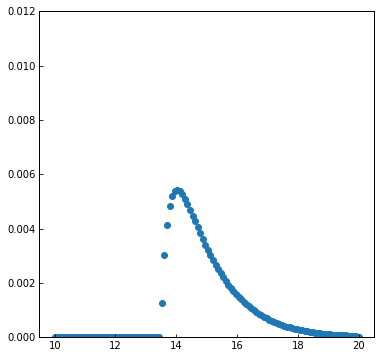

In [398]:
plt.scatter(list(reversed(e_pc_vals)), senss)
plt.ylim(0.0000001,0.012)
#plt.yscale('log')

(1e-07, 0.012)

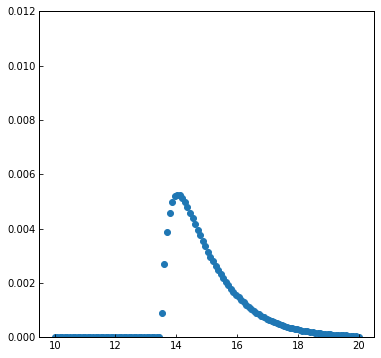

In [409]:
plt.scatter(list(reversed(e_pc_vals)), senss)
plt.ylim(0.0000001,0.012)
#plt.yscale('log')

In [430]:
#spinodal
print "Performing initial spinodal pass with {}x{} grid...".format(num_pts_p_c, num_pts_e_pc)
binodal = CalculateBoundary(p_c_vals, gamma, e_pc_vals, 
                            d_c, d_p, m_c, m_p, m, 
                            min_step, 'binodal')

Performing initial spinodal pass with 20x30 grid...
Performing (p_c, e_pc) iteration...
1.5278874536821953e-05
For 1.52788745368e-05 there is a root at e_pc = 14.9137931037
0.00013509741695716252
For 0.000135097416957 there is a root at e_pc = 13.6034482761
0.0002549159593775031
For 0.000254915959378 there is a root at e_pc = 13.2758620692
0.00037473450179784367
For 0.000374734501798 there is a root at e_pc = 13.2758620691
0.0004945530442181842
For 0.000494553044218 there is a root at e_pc = 13.2758620692
0.0006143715866385248
For 0.000614371586639 there is a root at e_pc = 13.2758620692
0.0007341901290588654
For 0.000734190129059 there is a root at e_pc = 13.2758620693
0.000854008671479206
For 0.000854008671479 there is a root at e_pc = 13.2758620694
0.0009738272138995465
For 0.0009738272139 there is a root at e_pc = 13.2758620695
0.0010936457563198872
For 0.00109364575632 there is a root at e_pc = 13.2758620697
0.0012134642987402277
For 0.00121346429874 there is a root at e_pc = 13.2

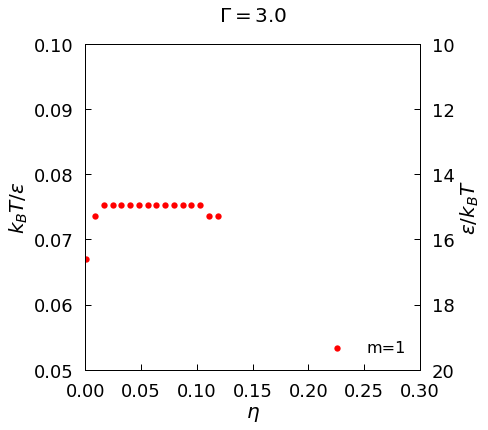

In [435]:
fig=plt.figure()

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#plot the data
plt.scatter(binodal[3], 1/np.array(binodal[2]), 
            c='red', marker="o", s=40, alpha=1.0, linewidths=0.0, label="m={}".format(m))

#add a legend
plt.legend(loc='lower right', fontsize=16, frameon=False)

#set the ranges
n_c_range = np.array([0.0001, 0.30])
e_inv_range = np.array([0.05, 0.10])
e_range = 1.0 / e_inv_range
plt.xlim(tuple(n_c_range))
plt.ylim(tuple(e_inv_range))
#plt.xscale('log')

###primary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlabel('$\eta$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$k_{B}T/\epsilon$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)
plt.title("$\Gamma = {}$".format(gamma), y=1.05, fontdict = title_font)

#make another axis
plt.twinx()
plt.ylim(e_range)

###secondary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.ylabel('$\epsilon / k_{B}T$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)

plt.savefig('./data/colloid_polymer_gamma={}.png'.format(gamma), bbox_inches='tight', dpi=100)

In [436]:
binodal[2]

[14.913793103659037,
 13.603448276052827,
 13.275862069162471,
 13.275862069133211,
 13.275862069164246,
 13.275862069223969,
 13.275862069294007,
 13.275862069384711,
 13.275862069500784,
 13.275862069661212,
 13.27586206989768,
 13.275862070281477,
 13.275862070997025,
 13.275862071924848,
 13.603448280568964,
 13.603448283912119]

In [257]:
gamma

3.0

# END

In [427]:
import scipy as sp

#performs grid search and labels each point as stable or unstable
def CalculateBoundary(p_c_vals, gamma, e_pc_vals,
                      d_c, d_p, m_c, m_p, m,
                      min_step, boundary_type,
                     ):


    #lists for storing the results
    boundary = [[],[],[],[]]

    #quantities to iterate over
    #p_c_vals_rev = list(reversed(p_c_vals))
    quants = {'p_c': p_c_vals,
              'e_pc': list(reversed(e_pc_vals))}

    #iteration permutations
    #iters = [('p_c', 'e_pc'), 
    #         ('e_pc', 'p_c')]
    iters = [('p_c', 'e_pc')]

    #perform the loops in both directions
    for iter_1, iter_2 in iters:
        
        print "Performing ({}, {}) iteration...".format(iter_1, iter_2)

        for quant_1 in quants[iter_1]:
            
            print quant_1

            #stacks to find crossover points iterating over quant_2
            value_queue = []
            quant_2_queue = []
            q0 = None

            for quant_2 in quants[iter_2]:

                #extract the values
                p_c = (iter_1 == 'p_c')*quant_1 + (iter_2 == 'p_c')*quant_2
                p_p = p_c*gamma
                e_pc = (iter_1 == 'e_pc')*quant_1 + (iter_2 == 'e_pc')*quant_2

                #perform the appropriate calculation
                if boundary_type == 'spinodal':
                    value = DA(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m, min_step)
                elif boundary_type == 'percolation':
                    value = Perc(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m)
                elif boundary_type == 'binodal':
                    value, q0 = PS(p_c+p_p, p_c/p_p, e_pc, d_c, d_p, m_c, m_p, m, q0)

                #manage the queue
                if len(value_queue) == 4:
                    value_queue.pop(0); quant_2_queue.pop(0)
                value_queue.append(value); quant_2_queue.append(quant_2)

                #count the number of unstable points encountered
                ####num_neg = num_neg + (value < 0.0)

                #if we have two positive and negative points interpolate to find the crossover and break
                ####if num_neg == 2:
                if len(value_queue) == 4:
                    value_queue_sgn = np.sign(value_queue)
                    if np.all(value_queue_sgn[0:2] + value_queue_sgn[2:] == 0):

                        #fit an akima spline
                        if quant_2_queue[-1] < quant_2_queue[0]:
                            fit = sp.interpolate.Akima1DInterpolator(list(reversed(quant_2_queue)), 
                                                                     list(reversed(value_queue)))
                        else:
                            fit = sp.interpolate.Akima1DInterpolator(quant_2_queue, 
                                                                     value_queue)
                        roots = fit.roots()

                        #select which one to use and append
                        num_roots = len(roots)
                        p_c_ = (iter_1 == 'p_c')*p_c + (iter_2 == 'p_c')*( (num_roots == 1)*roots[0] - (num_roots != 1) )
                        e_pc_ = (iter_1 == 'e_pc')*e_pc + (iter_2 == 'e_pc')*( (num_roots == 1)*roots[0] - (num_roots != 1) )
                        boundary[0].append( p_c_ )
                        boundary[1].append( p_p )
                        boundary[2].append( e_pc_ )
                        boundary[3].append( ((np.pi/6.0)*d_c**3)*p_c_ )
                        print "For {} there is a root at e_pc = {}".format(p_c_, e_pc_)
                        #break

    return boundary